# Chapter 3 - Building a Causal Graph

The notebook is a code companion to chapter 3[link text](https://) of the book [Causal Machine Learning](https://www.manning.com/books/causal-machine-learning) by Robert Osazuwa Ness.

In [1]:
#!pip install pgmpy
#!pip install dowhy
#!pip install pyro-ppl

## DAG Rock-throwing example

In [2]:
def true_dgp(jenny_inclination, brian_inclination, window_strength):    #A
    jenny_throws_rock = jenny_inclination > 0.5    #B
    brian_throws_rock = brian_inclination > 0.5    #B
    if jenny_throws_rock and brian_throws_rock:    #C
        strength_of_impact = 0.8    #C
    elif jenny_throws_rock or brian_throws_rock:    #D
        strength_of_impact = 0.6    #D
    else:    #E
        strength_of_impact = 0.0    #E
    window_breaks = window_strength < strength_of_impact    #F
    return jenny_throws_rock, brian_throws_rock, window_breaks

#A Input variables are numbers between 0 and 1
#B Jenny and Brian throw the rock if so inclined
#C If both throw the rock the strength of impact is .8
#D If one of them throws the strength of impact is .6
#E If neither throws the strength of impact is 0
#F The window breaks if strength of imact is greater than window strength


## Building the transportation DAG (Figure 3 - 2) in pgmpy

In [3]:
from pgmpy.models import BayesianNetwork
model = BayesianNetwork(    #A
       [
        ('A', 'E'),    #B
        ('S', 'E'),    #B
        ('E', 'O'),    #B
        ('E', 'R'),    #B
        ('O', 'T'),    #B
        ('R', 'T')     #B
     ]
)
#A pgmpy provides a BayesianNetwork class where we add the edges to the model.
#B Inut the DAG as a list of edges (tuples).


## Loading transportation data


In [4]:
import pandas as pd
url='https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'    #A 
data = pd.read_csv(url)
data


,A,S,E,O,R,T
0,adult,F,high,emp,small,train
1,young,M,high,emp,big,car
2,adult,M,uni,emp,big,other
3,old,F,uni,emp,big,car
4,young,F,uni,emp,big,car
...,...,...,...,...,...,...
495,young,M,high,emp,big,other
496,adult,M,high,emp,big,car
497,young,M,high,emp,small,train
498,young,M,high,emp,small,car


## Learning parameters for the causal Markov kernels in the transportation model

In [5]:
model = BayesianNetwork(
      [
        ('A', 'E'),
        ('S', 'E'),
        ('E', 'O'),
        ('E', 'R'),
        ('O', 'T'),
        ('R', 'T')
     ]
)
model.fit(data)    #A
causal_markov_kernels = model.get_cpds()    #B
print(causal_markov_kernels)    #B
#A The fit method on the BayesianNetwork object will estimate parameters from data (a pandas DataFrame).
#B Retrieve and view the causal Markov kernels learned by fit.

# Let's look at the structure of the causal Markov kernel for the transportation variable T.
cmk_T = causal_markov_kernels[-1]
print(cmk_T)

print(causal_markov_kernels[2])


[<TabularCPD representing P(A:3) at 0x7f44e81d1a50>, <TabularCPD representing P(E:2 | A:3, S:2) at 0x7f44e4e9af50>, <TabularCPD representing P(S:2) at 0x7f44e4e9a910>, <TabularCPD representing P(O:2 | E:2) at 0x7f44e77082d0>, <TabularCPD representing P(R:2 | E:2) at 0x7f44e7708690>, <TabularCPD representing P(T:3 | O:2, R:2) at 0x7f44e7708f10>]
+----------+---------------------+-----+--------------------+----------+
| O        | O(emp)              | ... | O(self)            | O(self)  |
+----------+---------------------+-----+--------------------+----------+
| R        | R(big)              | ... | R(big)             | R(small) |
+----------+---------------------+-----+--------------------+----------+
| T(car)   | 0.7034313725490197  | ... | 0.4444444444444444 | 1.0      |
+----------+---------------------+-----+--------------------+----------+
| T(other) | 0.13480392156862744 | ... | 0.3333333333333333 | 0.0      |
+----------+---------------------+-----+--------------------+--------

## Bayesian point estimation with a Dirichlet conjugate prior 

In [6]:
from pgmpy.estimators import BayesianEstimator    #A
estimator = BayesianEstimator(model, data)    #A
model.fit(
    data,
    estimator=BayesianEstimator,    #B
    prior_type="dirichlet",
    pseudo_counts=1    #C 
) 
causal_markov_kernels = model.get_cpds()     #D
cmk_T = causal_markov_kernels[-1]    #D
print(cmk_T)    #D
#A Import BayesianEstimator and initialize it on the model and data.
#B Pass the estimator object to the fit method.
#C pseudo_counts refers to the parameters of the Dirichlet prior. 
#D Extract the causal Markov kernels and view P(T|O,R).


+----------+--------------------+-----+--------------------+----------+
| O        | O(emp)             | ... | O(self)            | O(self)  |
+----------+--------------------+-----+--------------------+----------+
| R        | R(big)             | ... | R(big)             | R(small) |
+----------+--------------------+-----+--------------------+----------+
| T(car)   | 0.7007299270072993 | ... | 0.4166666666666667 | 0.5      |
+----------+--------------------+-----+--------------------+----------+
| T(other) | 0.1362530413625304 | ... | 0.3333333333333333 | 0.25     |
+----------+--------------------+-----+--------------------+----------+
| T(train) | 0.1630170316301703 | ... | 0.25               | 0.25     |
+----------+--------------------+-----+--------------------+----------+


## Training a causal graphical model with a latent variable.

In [7]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ExpectationMaximization as EM
url='https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'    #A
data = pd.read_csv(url)    #A
data_sans_E = data[['A', 'S', 'O', 'R', 'T']]    #B
model_with_latent = BayesianNetwork(
       [
        ('A', 'E'),
        ('S', 'E'),
        ('E', 'O'),
        ('E', 'R'),
        ('O', 'T'),
        ('R', 'T')
     ],
     latents={"E"}    #C
)
estimator = EM(model_with_latent, data_sans_E)    #D
cmks_with_latent = estimator.get_parameters(latent_card={'E': 2})    #D
print(cmks_with_latent[1].to_factor)    #E
#A Download the data and convert to a pandas data frame.
#B Keep all the columns except education E.
#C Indicate which variables are latent when training the model.
#D Run the structural expectation maximization algorithm to learn the causal Markov kernel for E.  You have to indicated the cardinality of the latent variable.
#E Print out the learned causal Markov kernel for E.  Print it as a factor object for legibility.


  0%|          | 0/100 [00:00<?, ?it/s]

<bound method TabularCPD.to_factor of <TabularCPD representing P(E:2 | A:3, S:2) at 0x7f44e7556390>>


## Inference on the trained causal graphical model

In [8]:
from pgmpy.inference import VariableElimination     #A
inference = VariableElimination(model)     
query1 = inference.query(['E'], evidence={"T": "train"})
query2 = inference.query(['E'], evidence={"T": "car"})
print("train")
print(query1)
print("car")
print(query2)
#A VariableElimination is an inference algorithm specific to graphical models.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

train
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.6162 |
+---------+----------+
| E(uni)  |   0.3838 |
+---------+----------+
car
+---------+----------+
| E       |   phi(E) |
+=========+==========+
| E(high) |   0.5586 |
+---------+----------+
| E(uni)  |   0.4414 |
+---------+----------+


## Implementing the trained causal model in pyro

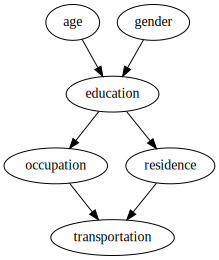

In [9]:
import torch
import pyro
from pyro.distributions import Categorical

A_alias = ['young', 'adult', 'old']    #B
S_alias = ['M', 'F']    #B
E_alias = ['high', 'uni']    #B
O_alias = ['emp', 'self']    #B
R_alias = ['small', 'big']    #B
T_alias = ['car', 'train', 'other']    #B

A_prob = torch.tensor([0.3,0.5,0.2])    #C
S_prob = torch.tensor([0.6,0.4])    #C
E_prob = torch.tensor([[[0.75,0.25], [0.72,0.28], [0.88,0.12]],    #C
                     [[0.64,0.36], [0.7,0.3], [0.9,0.1]]])    #C
O_prob = torch.tensor([[0.96,0.04], [0.92,0.08]])    #C
R_prob = torch.tensor([[0.25,0.75], [0.2,0.8]])    #C
T_prob = torch.tensor([[[0.48,0.42,0.1], [0.56,0.36,0.08]],    #C
                     [[0.58,0.24,0.18], [0.7,0.21,0.09]]])    #C

def model():    #D
   A = pyro.sample("age", Categorical(probs=A_prob))    #D
   S = pyro.sample("gender", Categorical(probs=S_prob))    #D
   E = pyro.sample("education", Categorical(probs=E_prob[S][A]))    #D
   O = pyro.sample("occupation", Categorical(probs=O_prob[E]))    #D
   R = pyro.sample("residence", Categorical(probs=R_prob[E]))    #D
   T = pyro.sample("transportation", Categorical(probs=T_prob[R][O]))    #D
   return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T}    #D

pyro.render_model(model)    #E

#B The categorical distribution only returns integers, so it’s useful to write the integers’ mapping to categorical outcome names.
#C For simplicity I’ll use rounded versions of parameters learned with the “fit” method in pgmpy (Listing 3-4), though I could have learned the parameters in a training procedure.
#D When you implement the model in pyro, you specify the causal DAG implicitly using code logic.
#E You can then generate a figure of the implied DAG using pyro.render_model().


## Inference on the causal model in pyro

Text(0.5, 1.0, 'P(education | Transportation = "train") - Importance Sampling')

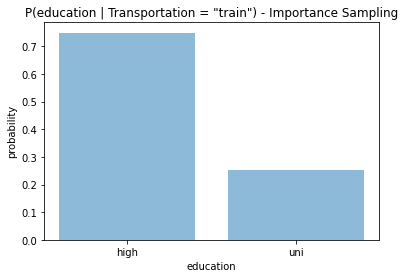

In [10]:
import numpy as np
import pyro
from pyro.distributions import Categorical
from pyro.infer import Importance, EmpiricalMarginal    #A
import matplotlib.pyplot as plt

conditioned_model = pyro.condition(    #B
    model,    #C
    data={'T':torch.tensor(1)}    #D
)

m = 5000    #E
posterior = pyro.infer.Importance(    #F
    conditioned_model,    #G
    num_samples=m    #H
).run()    #I
E_marginal = EmpiricalMarginal(posterior, "education")    #J
E_samples = [E_marginal().item() for _ in range(m)]    #J
E_unique, E_counts = np.unique(E_samples, return_counts=True)    #K
E_probs = E_counts / m    #K

plt.bar(E_unique, E_probs, align='center', alpha=0.5)    #L
plt.xticks(E_unique, E_alias)    #L
plt.ylabel('probability')    #L
plt.xlabel('education')    #L
plt.title('P(education | Transportation = "train") - Importance Sampling')    #L

#A We’ll use two inference related classes, ImportanceSampling and EmpiricalMarginal.
#B pyro.condition is a conditioning operation on the model.
#C It takes in the model,
#D and evidence for conditioning on.  The evidence is a dictionary that maps variable names to values. The need to specify variable names during inference is why we have the name argument in the calls to pyro.sample.  Here we condition on T=”train”.
#E I’ll run a inference algorithm that will generate m samples.
#F Namely, I use importance sampling. The Importance class constructs this inference algorithm.
#G It takes the conditioned model and the number of samples.
#I Run the random process algorithm with the run method.  The inference algorithm will generate from the joint probability of the variables we didn’t condition on (everything but T) given the variables we conditioned on (T).
#J However, we only care about T, so EmpiricalMarginal operates on the output of algorithm so we obtain only samples of T.
#K Based on these samples, I produce a Monte Carlo estimation of the probabilities in P(E|T=”train”).
#L Plot a visualization of the learned probabilities.


## Creating a DAG based on roles in causal effect inference

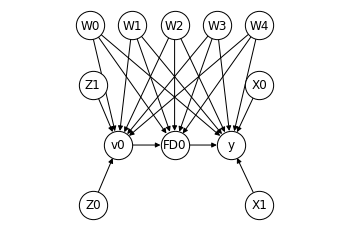

In [11]:
from dowhy import datasets

import networkx as nx
import matplotlib.pyplot as plt

sim_data = datasets.linear_dataset(    #A
    beta=10.0,
    num_treatments=1,    #B
    num_instruments=2,    #C
    num_effect_modifiers=2,    #D
    num_common_causes=5,    #E
    num_frontdoor_variables=1,    #F
    num_samples=100,
    
)
dag = nx.parse_gml(sim_data['gml_graph'])    #G
pos = {    #G
 'X0': (600, 350),    #G
 'X1': (600, 250),    #G
 'FD0': (300, 300),    #G
 'W0': (0, 400),    #G
 'W1': (150, 400),    #G
 'W2': (300, 400),    #G
 'W3': (450, 400),    #G
 'W4': (600, 400),    #G
 'Z0': (10, 250),    #G
 'Z1': (10, 350),    #G
 'v0': (100, 300),    #G
 'y': (500, 300)    #G
}    #G
options = {    #G
    "font_size": 12,    #G
    "node_size": 800,    #G
    "node_color": "white",    #G
    "edgecolors": "black",    #G
    "linewidths": 1,    #G
    "width": 1,    #G
}    #G
nx.draw_networkx(dag, pos, **options)    #G
ax = plt.gca()    #G
ax.margins(x=0.40)    #G
plt.axis("off")    #G
plt.show()    #G
 
#A datasets.linear_dataset generates a DAG from the specified variables.
#B I add one treatment variable, like V in Figure 3 - 18.
#C Z in Figure 3 - 18 is an example of an instrumental variable; a variable that is a cause of the treatment but its only causal path to the outcome is through the treatment.  Here I create two instruments.
#D X0 and X1 are in Figure 3 - 18 are examples of “effect modifiers” that help model heterogeneity in the causal effect.  Dowhy defines these as other causes of the outcome (though they needn’t be).  Here I create two effect modifiers.
#E I add 5 common causes, like the three W0, W1, and W2 in Figure 3 - 18.  Unlike the nuanced structure between in Figure 3 - 18, the structure here will be simple.
#F Front door variables are on the path between the treatment and the effect, like U in Figure 3 - 18.  Here I add one.
#G This code extracts the graph, creates a plotting layout, and plots the graph.
